<a href="https://colab.research.google.com/github/Mastroiani/TCC/blob/main/TTOAED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><FONT COLOR="yellow">PONTIFÍCIA UNIVERSIDADE CATÓLICA DE MINAS GERAIS</h1>
<h1><FONT COLOR="yellow">PÓS-GRADUAÇÃO LATO SENSU EM CIÊNCIA DE DADOS E BIG DATA</h1>
<h1><FONT COLOR="yellow">TCC - TRABALHO DE CONCLUSÃO DE CURSO</h1>
<br>
<ul>
<h3><strong><FONT SIZE=5>MODELOS SUPERVISIONADOS DE APRENDIZADO DE MÁQUINA APLICADOS À PREDIÇÃO DE INCOMPATIBILIDADE NO PREÇO DECLARADO DE MERCADORIAS IMPORTADAS
</h3>
</ul>


<h1> <FONT COLOR="yellow">NOTEBOOK 1 - COLETA, TRATAMENTO E ANÁLISE EXPLORATÓRIA DOS DADOS<h1>

<h1><FONT COLOR="blue">
1 - Instalação de módulos e importação de bibliotecas utilizadas
<hr <FONT COLOR="blue">
</h1>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install plotly
!pip install unidecode
!pip install wordcloud
!pip install nltk
!pip install lxml
!pip install graphviz

     |████████████████████████████████| 235 kB 36.4 MB/s 


In [3]:
import pandas as pd
import numpy as np
from unidecode import unidecode

import os
import re
from tqdm import tqdm
from time import time

import nltk
from nltk import FreqDist
from string import punctuation
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image  
import pydotplus
import pickle

import seaborn as sns
from sklearn import metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals.six import StringIO  

nltk.download('punkt')
nltk.download('stopwords')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

<h1><FONT COLOR="blue">
2 - Coleta de Dados
</h1>
<hr <FONT COLOR="blue"></hr>

<h2>Dataset de Itens de Importação</h2>
<b>
    Datasets oriundos do SISCORI, endereço eletrônico: <a href=https://siscori.receita.fazenda.gov.br/apoiosiscori/consulta.jsf>https://siscori.receita.fazenda.gov.br/apoiosiscori/consulta.jsf</a>
    <p><strong><u>Arquivos:</strong></u> CAPI72202xxx.CSV (CAPI72 = Capítulo 72 NCM; 202xxx = ano/mês: 202007 a 202105)
    <p>Itens de importação filtrados por:</p>
    <ul>
      <li> tipo de declaração (importação);</li>
      <li> ano de referência;</li>
      <li> mês de referência inicial e final;</li>
      <li> e Capítulo NCM</li>
      <p>  
    </ul>
</b> 

In [4]:
#definindo lista 'df_list' de arquivos para leitura

path = '/content/drive/MyDrive/DADOSTCC'
df_list = []
for file_name in os.listdir(path):
    df_list.append(pd.read_csv(
        f'{path}/{file_name}',
        sep='@',
        encoding='latin1' # Necessidade de uso desse enconder pela presenca de letras nao lidas pelo UTF-8
    ))

<h2>Criando o dataframe 'df', concatenando 'df_list'</h2>
  <b>
  <ul>
  <u>Registros:</u> itens de importação identificados pelo atributo 'NUMERO DE ORDEM'<p>'NUMERO DE ORDEM': composto pelos caracteres identificadores da Declaração de Importação (DI), da Adição e do item importado<p>
      <ul>
      DI <a>[:-10]</a><p>
      Adiçao<a>[:-5]</a><p>
      Item<a>[-5:]</a>
      </ul>
  </ul>
  <b>

In [5]:
df = pd.concat(df_list)

if(df.shape[1] > 25):
    df = df.iloc[:,:-1]

print(df.shape)
df.head(2)

(118589, 25)


,NUMERO DE ORDEM,ANOMES,COD.NCM,DESCRICAO DO CODIGO NCM,PAIS,PAIS DE ORIGEM,PAIS.1,PAIS DE AQUISICAO,UND.ESTAT.,UNIDADE DE MEDIDA,UNIDADE COMERC.,DESCRICAO DO PRODUTO,QTDE ESTATISTICA,PESO LIQUIDO,VMLE DOLAR,VL FRETE DOLAR,VL SEGURO DOLAR,VALOR UN.PROD.DOLAR,QTD COMERCIAL.,TOT.UN.PROD.DOLAR,UNIDADE DESEMBARQUE,UNIDADE DESEMBARACO,INCOTERM,NAT.INFORMACAO,SITUACAO DO DESPACHO
0,962930000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,756,AFRICA DO SUL,756,AFRICA DO SUL,10,QUILOGRAMA LIQUIDO,QUILOGRAMA LIQUIDO,CS215 - FERROMANGANES CONTENDO PESO MAIOR DE 2...,"20000,00000","20000,00000","30190,23","926,59","0,00","1,5510760","20000,00000","31021,5200000",N/INFORMADO,PORTO DO RIO DE JANEIRO,CFR,EFETIVA,DI DESEMBARAÇADA
1,745630000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,INDIA,767,SUICA,10,QUILOGRAMA LIQUIDO,TONEL.METR.LIQ.,PEDIDO: 4512845335 CODIGO ITEM:20001208 FEMNAC...,"360000,00000","360000,00000","354981,62","13999,99","207,13","1015,0000000","360,00000","365400,0000000",N/INFORMADO,PORTO DO RIO DE JANEIRO,CFR,EFETIVA,DI DESEMBARAÇADA


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118589 entries, 0 to 12722
Data columns (total 25 columns):
 #   Column                                                                                                                                                                                                                                                      Non-Null Count   Dtype 
---  ------                                                                                                                                                                                                                                                      --------------   ----- 
 0   NUMERO DE ORDEM                                                                                                                                                                                                                                             118589 non-null  int64 
 1   ANOMES                                    

<h2>Dataset de cotação de matéria-prima</h2>
<p>Leitura dos dados de cotação da página web de referência:
<p><a href=https://mepsinternational.com/gb/en/products/world-steel-prices>https://mepsinternational.com/gb/en/products/world-steel-prices</a>
<p>Nota: página alterada e atualizada mensalmente; a extração atual englobou os meses de jul-2020 a mai-2021</p>


In [7]:
URL = 'https://mepsinternational.com/gb/en/products/world-steel-prices'

#armazenando dados de cotações no dataframe df_cotacao
df_cotacao = pd.read_html(URL,match='Wire Rod')[0]
df_cotacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Month                       16 non-null     object 
 1   Hot Rolled Coil             11 non-null     float64
 2   Hot Rolled Plate            11 non-null     float64
 3   Cold Rolled Coil            11 non-null     float64
 4   Hot Dipped Galvanised Coil  11 non-null     float64
 5   Electro Zinc Coated Coil    11 non-null     float64
 6   Wire Rod                    11 non-null     float64
 7   Sections & Beams            11 non-null     float64
 8   Rebar                       11 non-null     float64
 9   Merchant Bar                11 non-null     float64
dtypes: float64(9), object(1)
memory usage: 1.4+ KB


<h3>Definindo dataframe 'df_wire_rod'</h3>

In [8]:
df_wire_rod= df_cotacao[['Month','Wire Rod']].copy().dropna()
df_wire_rod['Wire Rod'] = df_wire_rod['Wire Rod'].apply(lambda x: x/1000)
df_wire_rod

,Month,Wire Rod
0,Jul-2020,0.548
1,Aug-2020,0.555
2,Sep-2020,0.578
3,Oct-2020,0.587
4,Nov-2020,0.602
5,Dec-2020,0.637
6,Jan-2021,0.772
7,Feb-2021,0.798
8,Mar-2021,0.805
9,Apr-2021,0.806


In [9]:
#exportando 'df_wire_rod' em formato csv
df_wire_rod.to_csv('/content/drive/MyDrive/wire_rod.csv',index=False)

<h1><FONT COLOR="blue">3 - Processamento e Tratamento dos dados</h1>
<hr <FONT COLOR="blue">

<h2>Normalizando as colunas de 'df'</h2>

In [10]:
#Converte rótulos das colunas para letras minúsculas e acrescenta "_" entre palavras
df.columns = ["_".join(re.findall(r'\w+',col)).lower() for col in df.columns]

#função 'norm_num': altera caracter "," para "." e "." para ""
def norm_num(num):
    return float(str(num).replace(".","").replace(",","."))

#função 'norm': usa biblioteca de expressões regulares para transpor palavras maiúsculas em minúsculas
def norm(text):
    return " ".join(re.findall(r'\w+',text)).lower()

In [11]:
for column in [
    'qtde_estatistica',
    'peso_liquido',
    'vmle_dolar',
    'vl_frete_dolar',
    'vl_seguro_dolar',
    'valor_un_prod_dolar',
    'qtd_comercial',
    'tot_un_prod_dolar',
    'und_estat'
    ]:
    df[column] = df[column].apply(lambda x: norm_num(x))
    
df['unidade_desembaraco'] = df['unidade_desembaraco'].apply(lambda x: norm(x))
df['pais_de_origem'] = df['pais_de_origem'].apply(lambda x: norm(x))
df['pais_de_aquisicao'] = df['pais_de_aquisicao'].apply(lambda x: norm(x))
df['nat_informacao'] = df['nat_informacao'].apply(lambda x: norm(x))
df['situacao_do_despacho'] = df['situacao_do_despacho'].apply(lambda x: norm(x))

df.head(2)

,numero_de_ordem,anomes,cod_ncm,descricao_do_codigo_ncm,pais,pais_de_origem,pais_1,pais_de_aquisicao,und_estat,unidade_de_medida,unidade_comerc,descricao_do_produto,qtde_estatistica,peso_liquido,vmle_dolar,vl_frete_dolar,vl_seguro_dolar,valor_un_prod_dolar,qtd_comercial,tot_un_prod_dolar,unidade_desembarque,unidade_desembaraco,incoterm,nat_informacao,situacao_do_despacho
0,962930000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,756,africa do sul,756,africa do sul,10.0,QUILOGRAMA LIQUIDO,QUILOGRAMA LIQUIDO,CS215 - FERROMANGANES CONTENDO PESO MAIOR DE 2...,20000.0,20000.0,30190.23,926.59,0.00,1.551076,20000.0,31021.520,N/INFORMADO,porto do rio de janeiro,CFR,efetiva,di desembaraçada
1,745630000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,india,767,suica,10.0,QUILOGRAMA LIQUIDO,TONEL.METR.LIQ.,PEDIDO: 4512845335 CODIGO ITEM:20001208 FEMNAC...,360000.0,360000.0,354981.62,13999.99,207.13,1015.000000,360.0,365400.000,N/INFORMADO,porto do rio de janeiro,CFR,efetiva,di desembaraçada
2,745630000200001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,india,767,suica,10.0,QUILOGRAMA LIQUIDO,QUILOGRAMALIQUIDO,FERRO MANGANÊS ALTO CARBONO ...,45000.0,45000.0,44372.71,1749.99,25.89,1.015000,45000.0,45675.000,N/INFORMADO,porto do rio de janeiro,CFR,efetiva,di desembaraçada
3,1140420000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,361,india,361,india,10.0,QUILOGRAMA LIQUIDO,TONELADAMETRICA,FERRO MANGANES ALTO CARBONO --> QUALIDADE QUIM...,729000.0,729000.0,672540.33,31611.76,249.44,960.000000,729.0,699840.000,N/INFORMADO,alf fortaleza,CFR,efetiva,di desembaraçada
4,233250000100001,202007,72021100,FERROMANGANÊS C/PESO + DE 2% D,756,africa do sul,756,africa do sul,10.0,QUILOGRAMA LIQUIDO,QUILOGRAMA LIQUIDO,CS215 - FERROMANGANES CONTENDO PESO MAIOR DE 2...,20000.0,20000.0,29497.04,924.46,0.00,1.516298,20000.0,30325.956,N/INFORMADO,porto do rio de janeiro,CFR,efetiva,di desembaraçada


<h2>Verificando dados incompletos (nulos) e redundantes (duplicados)</h2>

In [12]:
print(df.isna().sum())

numero_de_ordem            0
anomes                     0
cod_ncm                    0
descricao_do_codigo_ncm    0
pais                       0
pais_de_origem             0
pais_1                     0
pais_de_aquisicao          0
und_estat                  0
unidade_de_medida          0
unidade_comerc             0
descricao_do_produto       0
qtde_estatistica           0
peso_liquido               0
vmle_dolar                 0
vl_frete_dolar             0
vl_seguro_dolar            0
valor_un_prod_dolar        0
qtd_comercial              0
tot_un_prod_dolar          0
unidade_desembarque        0
unidade_desembaraco        0
incoterm                   0
nat_informacao             0
situacao_do_despacho       0
dtype: int64


In [13]:
df.isnull().sum()

numero_de_ordem            0
anomes                     0
cod_ncm                    0
descricao_do_codigo_ncm    0
pais                       0
pais_de_origem             0
pais_1                     0
pais_de_aquisicao          0
und_estat                  0
unidade_de_medida          0
unidade_comerc             0
descricao_do_produto       0
qtde_estatistica           0
peso_liquido               0
vmle_dolar                 0
vl_frete_dolar             0
vl_seguro_dolar            0
valor_un_prod_dolar        0
qtd_comercial              0
tot_un_prod_dolar          0
unidade_desembarque        0
unidade_desembaraco        0
incoterm                   0
nat_informacao             0
situacao_do_despacho       0
dtype: int64

In [14]:
df.duplicated().sum()

0

<h2>Criando dataframe 'df_filtrado', através da filtragem de atributos de interesse de 'df'</h2>
<ul>
    <li>cod_ncm = <strong>72172090</strong></li>
    Obs.: corresponde a mercadoria em análise - fio de aço galvanizado com baixo teor de carbono
</ul>

In [15]:
df_filtrado = df[df['cod_ncm'] == 72172090].copy()

df_filtrado.shape

(1543, 25)

<h2>Criando novas colunas</h2>
<ul>
<li>Criando 'adicao' a partir de 'numero_de_ordem': adicao = numero_de_ordem[:-5]</li>
<li>Renomeando 'numero_de_ordem' para 'item'</li>
<li>Criando 'ano' e 'mes' a partir de  'anomes'</li>
<li>Criando colunas de rateio: 'frete_rateado', 'peso_liquido_rateado', 'seguro_rateado'</li>
<li>Criando coluna 'total_unitario_FOB'</li>
</ul>

In [16]:
numero_de_ordem = df_filtrado['numero_de_ordem'].copy().astype(str).to_list()
ano_mes = df_filtrado['anomes'].copy().astype(str).to_list()

In [17]:
adicao = []
ano = []
mes = []

for num_ordem, ano_me in zip(numero_de_ordem,ano_mes):
    adicao.append(num_ordem[:-5])
    ano.append(ano_me[:4])
    mes.append(ano_me[-2:])
    
df_filtrado.insert(0,'adicao',adicao)
df_filtrado.insert(2,'ano',ano)
df_filtrado.insert(3,'mes',mes)
df_filtrado.drop(['anomes'],axis=1,inplace=True)
df_filtrado.rename(columns={'numero_de_ordem':'item'}, inplace=True)
df_filtrado.sort_values(by=['ano','mes','item'],inplace=True)
df_filtrado.head()

,adicao,item,ano,mes,cod_ncm,descricao_do_codigo_ncm,pais,pais_de_origem,pais_1,pais_de_aquisicao,und_estat,unidade_de_medida,unidade_comerc,descricao_do_produto,qtde_estatistica,peso_liquido,vmle_dolar,vl_frete_dolar,vl_seguro_dolar,valor_un_prod_dolar,qtd_comercial,tot_un_prod_dolar,unidade_desembarque,unidade_desembaraco,incoterm,nat_informacao,situacao_do_despacho
2812,199600001,19960000100001,2020,07,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",827,turquia,827,turquia,10.0,QUILOGRAMA LIQUIDO,TONELADA,"ARAME GALVANIZADO EM ROLOS - DIAMETRO: 5,20mm ...",100486.0,100486.0,62609.85,1956.00,100.49,635.000201,49.776,31607.770000,PORTO DE RIO GRANDE,alf porto alegre,CIF,efetiva,di desembaraçada
2813,199600001,19960000100002,2020,07,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",827,turquia,827,turquia,10.0,QUILOGRAMA LIQUIDO,TONELADA,"ARAME GALVANIZADO EM ROLOS - DIAMETRO: 3,80mm ...",100486.0,100486.0,62609.85,1956.00,100.49,645.000197,25.373,16365.590001,PORTO DE RIO GRANDE,alf porto alegre,CIF,efetiva,di desembaraçada
2814,199600001,19960000100003,2020,07,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",827,turquia,827,turquia,10.0,QUILOGRAMA LIQUIDO,TONELADA,"ARAME GALVANIZADO EM ROLOS - DIAMETRO: 6,10mm ...",100486.0,100486.0,62609.85,1956.00,100.49,635.000197,25.337,16088.999999,PORTO DE RIO GRANDE,alf porto alegre,CIF,efetiva,di desembaraçada
2796,2042600004,204260000400001,2020,07,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",160,china republica pop,351,hong kong,10.0,QUILOGRAMA LIQUIDO,QUILOGRAMALIQUIDO,ACCETMS-22815A - FIO DE AÇO GALVANIZAÇAO COM D...,5.0,5.0,15.00,159.73,0.00,3.000000,5.000,15.000000,N/INFORMADO,itajai,EXW,efetiva,di desembaraçada
2863,2073800012,207380001200001,2020,07,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",399,japao,399,japao,10.0,QUILOGRAMA LIQUIDO,KILOGRAMA,"ANEL DE ARAME - SWMGS-2, 0,85mm - DIAMETRO 0,8...",120.0,120.0,296.12,28.25,0.19,2.687371,120.000,322.484496,N/INFORMADO,porto de santos,CFR,efetiva,di desembaraçada


<h2>Agrupando e rateando valores de:</h2>
<ul>
    <li>Peso Liquido</li>
    <li>Valor Frete</li>
    <li>Valor Seguro</li>
</ul>

In [18]:
grupos_index = df_filtrado['adicao'].value_counts().index

grupos_index = [int(x) for x in grupos_index]
grupos_index.sort()
df_filtrado.sort_index(inplace=True) # Ordenou os index do dataframe

<h4>Peso Liquido Rataedo e Valor Frete Rateado</h4>

In [19]:
list_aux = [] # objeto auxiliar de armazenamento das variáveis 'peso_liquido_rateado' e 'valor_frete_rateado' que serão criadas abaixo

for adicao in tqdm(grupos_index):  
    #agrupando registros de 'adicao' em 'aux'
    aux= df_filtrado[df_filtrado['adicao'] == str(adicao)].copy()

    #soma 'qtd_comercial' dos registros agrupados em 'aux'  
    qtd_comercial = aux['qtd_comercial'] 
    soma_qtd_comercial = sum(qtd_comercial)

    #realiza rateio de 'peso_liquido' e 'vl_frete_dolar', e armazena em 'aux'
    peso_liquido = aux['peso_liquido']
    vl_frete_dolar = aux['vl_frete_dolar']
    aux['peso_liquido_rateado'] = (qtd_comercial/soma_qtd_comercial)*peso_liquido
    aux['valor_frete_rateado'] = (qtd_comercial/soma_qtd_comercial)*vl_frete_dolar

    #armazena registros de 'aux' em 'list_aux'
    list_aux.append(aux)
        
# Concatenando 'list_aux' a 'df_filtrado'        
df_filtrado = pd.concat(list_aux)
df_filtrado.shape

100%|██████████| 721/721 [00:02<00:00, 339.51it/s]


(1543, 29)

<h4>Seguro Rateado</h4>

In [20]:
list_aux2 = [] # objeto auxiliar de armazenamento da variáveis 'seguro_rateado' que serão criadas abaixo

for adicao in tqdm(grupos_index):
    #agrupando registros de 'adicao' em 'aux_2'
    aux_2 = df_filtrado[df_filtrado['adicao'] == str(adicao)].copy() 

    #soma 'tot_un_prod_dolar' dos registros agrupados em 'aux_2' 
    total_unitario = aux_2['tot_un_prod_dolar']
    soma_total_unitario = sum(total_unitario)
    
    #realiza rateio de 'vl_seguro_dolar', e armazena em 'aux_2'
    vl_seguro_dolar = aux_2['vl_seguro_dolar']
    aux_2['seguro_rateado'] = (total_unitario/soma_total_unitario)*vl_seguro_dolar

    #armazena registros de 'aux_2' em 'list_aux2'
    list_aux2.append(aux_2)
        
# Concatenando 'list_aux2' a 'df_filtrado'         
df_filtrado = pd.concat(list_aux2)
df_filtrado.shape

100%|██████████| 721/721 [00:01<00:00, 471.04it/s]


(1543, 30)

<h2>Total Unitário FOB</h2>
<b>Necessário subtrair 'valor_frete_rateado' e 'seguro_rateado' para INCOTERMS distintos de FOB/FCA/EXW</b>

In [21]:
total_unitario_list = [] # objeto auxiliar de armazenamento das variáveis 'total_unitario_fob' que serão criadas abaixo

for row_ in tqdm(df_filtrado.iloc,total=df_filtrado.shape[0]):
    total_unitario = row_['tot_un_prod_dolar']
    
    if(row_['incoterm'][0] == 'F' or row_['incoterm'][0] == 'E'):
        total_unitario_list.append(total_unitario)
    else:
        total_unitario_list.append(total_unitario - row_['valor_frete_rateado'] - row_['seguro_rateado'])

df_filtrado['total_unitario_fob'] = total_unitario_list
df_filtrado.shape

100%|██████████| 1543/1543 [00:00<00:00, 4699.94it/s]


(1543, 31)

<h2>Criando Coluna FOB/KG</h2>
<p>Dividindo a coluna calculada <em><strong>'total_unitario_fob'</strong></em> pela coluna calculada <em><strong>'peso_liquido_rateado'</strong></em></p>

In [22]:
df_filtrado['fob_kg'] = df_filtrado['total_unitario_fob']/df_filtrado['peso_liquido_rateado']
df_filtrado.shape

(1543, 32)

In [23]:
df_filtrado.head(2)

,adicao,item,ano,mes,cod_ncm,descricao_do_codigo_ncm,pais,pais_de_origem,pais_1,pais_de_aquisicao,und_estat,unidade_de_medida,unidade_comerc,descricao_do_produto,qtde_estatistica,peso_liquido,vmle_dolar,vl_frete_dolar,vl_seguro_dolar,valor_un_prod_dolar,qtd_comercial,tot_un_prod_dolar,unidade_desembarque,unidade_desembaraco,incoterm,nat_informacao,situacao_do_despacho,peso_liquido_rateado,valor_frete_rateado,seguro_rateado,total_unitario_fob,fob_kg
3311,95300002,9530000200001,2020,12,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",160,china republica pop,160,china republica pop,10.0,QUILOGRAMA LIQUIDO,QUILO,"Arame de aco 3,00 mm patenteado e galvanizado ...",49761.0,49761.0,44094.67,4535.3,191.46,0.88,24857.0,21874.16,N/INFORMADO,porto de santos,FOB,efetiva,di desembaraçada,24857.0,2265.508171,95.639582,21874.16,0.88
3312,95300002,9530000200002,2020,12,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",160,china republica pop,160,china republica pop,10.0,QUILOGRAMA LIQUIDO,QUILO,"Arame de aco 3,00 mm patenteado e galvanizado ...",49761.0,49761.0,44094.67,4535.3,191.46,0.88,14816.0,13038.08,N/INFORMADO,porto de santos,FOB,efetiva,di desembaraçada,14816.0,1350.354792,57.005915,13038.08,0.88


<h2>Filtrando 'df_filtrado' quanto aos seguintes atributos de interesse</h2>
<ul>
    <li>natureza_informação: <strong>efetiva</strong> (regime comum de importação e não administrativo ou especial)</li>
    <li>situação_do_despacho: <strong>di desembaraçada </strong> (operação de importação efetivada)</li>
</ul>

In [24]:
print('Shape antes da filtragem',df_filtrado.shape)
df_filtrado = df_filtrado[df_filtrado['nat_informacao'] == 'efetiva']
df_filtrado = df_filtrado[df_filtrado['situacao_do_despacho'] == 'di desembaraçada']
print('Shape depois da filtragem',df_filtrado.shape)

Shape antes da filtragem (1543, 32)
Shape depois da filtragem (1512, 32)


<h2>Remoção de unidades comerciais (atributos) não relevantes</h2>
<b>Tal ajuste visa considerar apenas os registros de produtos com unidade comercial relacionada a unidade de medida estatística oficial (Kg)</b> 

In [25]:
df_filtrado['unidade_comerc'] = df_filtrado['unidade_comerc'].apply(lambda x: x.lower())

<p>Verificando as unidades comerciais presentes</p>

In [26]:
freq_unid_com = FreqDist(df_filtrado['unidade_comerc'].values)
pd.DataFrame(list(dict(freq_unid_com).items()),columns=['unidade_comerc','freq'])

,unidade_comerc,freq
0,quilo,71
1,tonelada,370
2,rolo,34
3,peca,30
4,quilograma liquido,243
5,bobinas,8
6,tonelada metrica,111
7,quilogrmaliquido,1
8,quilogramaliquido,9
9,caixas,21


<p>Removendo itens com unidades comerciais verificadas como não relevantes</p>

In [27]:
def search_unid_comer(text):
    
    text = norm(text)
    achou = False
    for comparador in [
        'caixa',
        'caixas',
        'carretel',
        'pacote',
        'pacotes',
        'peca',
        'pecas',
        'peças',
        'pé',
        'rolo',
        'rolos',
        'sachet',
        'sacos',
        'unidade',
        'metro', 
        'metros'
        ]:
        if(comparador in ['metro','metros']):
            if(text == comparador):
                achou = True
                return False
        elif(re.search(unidecode(comparador),unidecode(text))):
            achou = True
            return False
    if(not achou):
        return text

df_filtrado['unidade_comerc'] = df_filtrado['unidade_comerc'].apply(lambda x: search_unid_comer(x))
df_filtrado = df_filtrado[df_filtrado['unidade_comerc'] != False]

df_filtrado.shape

(1296, 32)

<h2>Verificando Descrição do Item Importado ('descricao_do_produto')</h2>

<p>Obs.: esse ajuste visa considerar apenas os registros de produtos com descrição de produto sem menção de cobertura, pintura e/ou com aplicação especial (óptica)</p>

In [28]:
df_filtrado['descricao_do_produto'] = df_filtrado['descricao_do_produto'].apply(lambda x: x.lower())

# função para remover stopwords e tokenizar
def norm_nltk(text):
    stop_word = nltk.corpus.stopwords.words('portuguese')

    tokens = nltk.word_tokenize(text.lower(),language='portuguese')
    tokens = [token for token in tokens if token not in stop_word]
    tokens = [token for token in tokens if token not in punctuation]

    aux = []
    for token in tokens:
        if(not re.findall(r'[0-9]+',token)):
            aux.append(unidecode(token))
    tokens = aux
    return " ".join(tokens)

df_filtrado['descricao_do_produto'] = df_filtrado['descricao_do_produto'].apply(lambda x: norm_nltk(x))

In [29]:
df_filtrado['descricao_do_produto'].head()

3311    arame aco mm patenteado galvanizado fogo camad...
3312    arame aco mm patenteado galvanizado fogo camad...
3313    arame aco mm patenteado galvanizado fogo camad...
2812    arame galvanizado rolos diametro camada zinco ...
2813    arame galvanizado rolos diametro camada zinco ...
Name: descricao_do_produto, dtype: object

<p>Verificando palavras utilizadas na descrição do produto</p>

In [30]:
ls_df_filtrado = list(df_filtrado['descricao_do_produto'].values)
str_ls = " ".join(ls_df_filtrado)
palavras=nltk.word_tokenize(str_ls)

freq_desc_prod = FreqDist(palavras)
pd.DataFrame(list(dict(freq_desc_prod).items()),columns=['palavras','freq'])

,palavras,freq
0,arame,1144
1,aco,955
2,mm,444
3,patenteado,88
4,galvanizado,1304
...,...,...
602,largura,1
603,demoninado,9
604,rod,1
605,grande,1


<p>Removendo itens com palavras verificadas como não relevantes no campo 'descricao_produto'</p>
        



In [31]:
def search_desc_prod(text):
    text = text.lower()
    achou = False
    for comparador in [
            'aluminio',
            'aluminio-liga',
            'ferro ',
            'plastico',
            'plasticos',
            'plasticos.utilizacao',
            'pvc',
            'policloreto',
            'polietileno',
            'polimericos',
            'polimeros',
            'polipropileno',
            'vinila',
            'preto',
            'prata',
            'branca',
            'branco',
            'verde',
            'azul',
            'brilho',                     
            'otica',
            'optico',
            'optica',
            'mascara',
            'mascaras',
            'mask',
            'laca '            
            ]:
            if(re.search(unidecode(comparador),unidecode(text))):
                achou = True
                return False
    if(not achou):
        return text

df_filtrado['descricao_do_produto'] = df_filtrado['descricao_do_produto'].apply(lambda x: search_desc_prod(x))
df_filtrado = df_filtrado[df_filtrado['descricao_do_produto'] != False]
df_filtrado.shape

(1182, 32)

In [32]:
ls_df_filtrado2 = list(df_filtrado['descricao_do_produto'].values)
str_ls2 = " ".join(ls_df_filtrado2)
palavras2=nltk.word_tokenize(str_ls2)

freq_desc_prod2 = FreqDist(palavras2)
pd.DataFrame(list(dict(freq_desc_prod2).items()),columns=['palavras','freq'])

,palavras,freq
0,arame,1051
1,aco,834
2,mm,422
3,patenteado,88
4,galvanizado,1197
...,...,...
473,largura,1
474,demoninado,9
475,rod,1
476,grande,1


<h2>Plotagem da Nuvem de Palavras relativa a descrição do item importado<h2>

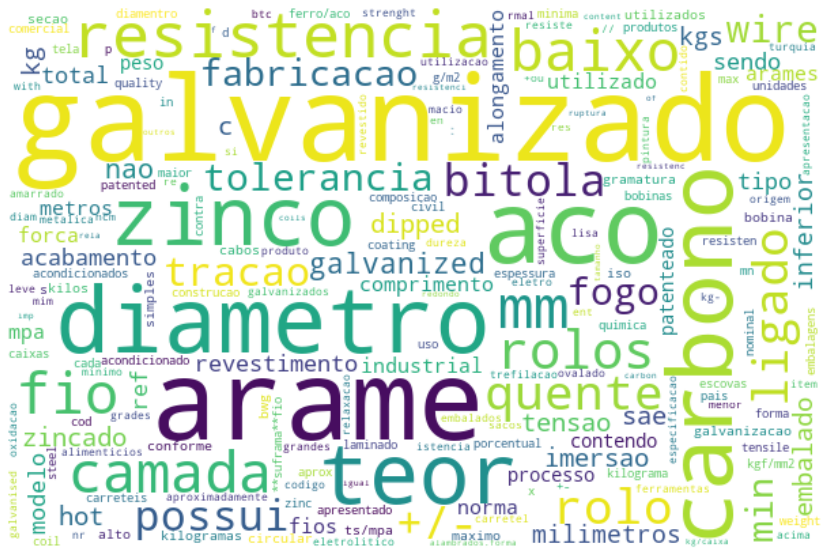

In [51]:
plt.subplots(figsize = (15,10))

wordcloud = WordCloud(
                    background_color = 'white',
                    width = 600,
                    height = 400
                        ).generate_from_frequencies(freq_desc_prod2)
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis('off')
plt.show()

<h2>Dataframe 'df_filtrado' após processamento e limpeza dos dados</h2>

In [34]:
df_filtrado.shape

(1182, 32)

In [35]:
df_filtrado.head(2)

,adicao,item,ano,mes,cod_ncm,descricao_do_codigo_ncm,pais,pais_de_origem,pais_1,pais_de_aquisicao,und_estat,unidade_de_medida,unidade_comerc,descricao_do_produto,qtde_estatistica,peso_liquido,vmle_dolar,vl_frete_dolar,vl_seguro_dolar,valor_un_prod_dolar,qtd_comercial,tot_un_prod_dolar,unidade_desembarque,unidade_desembaraco,incoterm,nat_informacao,situacao_do_despacho,peso_liquido_rateado,valor_frete_rateado,seguro_rateado,total_unitario_fob,fob_kg
3311,95300002,9530000200001,2020,12,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",160,china republica pop,160,china republica pop,10.0,QUILOGRAMA LIQUIDO,quilo,arame aco mm patenteado galvanizado fogo camad...,49761.0,49761.0,44094.67,4535.3,191.46,0.88,24857.0,21874.16,N/INFORMADO,porto de santos,FOB,efetiva,di desembaraçada,24857.0,2265.508171,95.639582,21874.16,0.88
3312,95300002,9530000200002,2020,12,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",160,china republica pop,160,china republica pop,10.0,QUILOGRAMA LIQUIDO,quilo,arame aco mm patenteado galvanizado fogo camad...,49761.0,49761.0,44094.67,4535.3,191.46,0.88,14816.0,13038.08,N/INFORMADO,porto de santos,FOB,efetiva,di desembaraçada,14816.0,1350.354792,57.005915,13038.08,0.88


In [52]:
# organizando registros por 'ano', 'mes' e 'item', e resetando índice
df_filtrado.sort_values(by=['ano','mes','item'],inplace=True)
df_filtrado.reset_index(drop=True,inplace=True)
df_filtrado.head(2)

,adicao,item,ano,mes,cod_ncm,descricao_do_codigo_ncm,pais,pais_de_origem,pais_1,pais_de_aquisicao,und_estat,unidade_de_medida,unidade_comerc,descricao_do_produto,qtde_estatistica,peso_liquido,vmle_dolar,vl_frete_dolar,vl_seguro_dolar,valor_un_prod_dolar,qtd_comercial,tot_un_prod_dolar,unidade_desembarque,unidade_desembaraco,incoterm,nat_informacao,situacao_do_despacho,peso_liquido_rateado,valor_frete_rateado,seguro_rateado,total_unitario_fob,fob_kg,cotacao,incompatibil
0,199600001,19960000100001,2020,07,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",827,turquia,827,turquia,10.0,QUILOGRAMA LIQUIDO,tonelada,arame galvanizado rolos diametro camada zinco ...,100486.0,100486.0,62609.85,1956.0,100.49,635.000201,49.776,31607.770000,PORTO DE RIO GRANDE,alf porto alegre,CIF,efetiva,di desembaraçada,49776.0,968.909659,49.580827,30589.279514,0.614539,0.548,0
1,199600001,19960000100002,2020,07,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",827,turquia,827,turquia,10.0,QUILOGRAMA LIQUIDO,tonelada,arame galvanizado rolos diametro camada zinco ...,100486.0,100486.0,62609.85,1956.0,100.49,645.000197,25.373,16365.590001,PORTO DE RIO GRANDE,alf porto alegre,CIF,efetiva,di desembaraçada,25373.0,493.895548,25.671520,15846.022934,0.624523,0.548,0


<h1>Integração de Datasets</h1>
<h2>Integrando informação de cotação da matéria-prima (Wire Rod) ao dataset de itens importados </h2>
<ul>
<li>Criando a coluna 'cotacao' em 'df_filtrado', de modo a integrar registros mensais de cotação de 'df_wire_rod'</li><p> 
<li>Criando a coluna 'incompatibil':
<p>Comparação do <strong>valor FOB/KG do produto manufaturado</strong> com o valor de <strong> cotação mensal internacional da matéria-prima (Wire Rod)</strong>; visa segregar os registros de itens de importação em duas classes: (0) valor declarado compatível; (1) valor declarado incompatível.</li>
</ul>

In [37]:
# dicionário auxiliar para mapeamento numérico dos meses do ano
map_mes = {
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
    }

In [38]:
wire_rod_list = [] # objeto auxiliar de armazenamento das variáveis 'cotacao' que serão criadas abaixo
aux_3 = [] # objeto auxiliar de armazenamento das classes de 'incompatibil' que serão criadas abaixo

for row_ in df_filtrado.iloc:
    wire_rod = df_wire_rod[df_wire_rod['Month'] == f"{map_mes[row_['mes']]}-{row_['ano']}"]['Wire Rod'].values[0]
    wire_rod_list.append(wire_rod)
    if(row_['fob_kg'] < wire_rod):
         aux_3.append(1) # incompatível
    else:
         aux_3.append(0) # compatível

# armazenando objetos auxiliares em 'df_filtrado'   
df_filtrado['cotacao'] = wire_rod_list
df_filtrado['incompatibil'] = aux_3

In [39]:
df_filtrado.shape

(1182, 34)

In [40]:
df_filtrado.head(2)

,adicao,item,ano,mes,cod_ncm,descricao_do_codigo_ncm,pais,pais_de_origem,pais_1,pais_de_aquisicao,und_estat,unidade_de_medida,unidade_comerc,descricao_do_produto,qtde_estatistica,peso_liquido,vmle_dolar,vl_frete_dolar,vl_seguro_dolar,valor_un_prod_dolar,qtd_comercial,tot_un_prod_dolar,unidade_desembarque,unidade_desembaraco,incoterm,nat_informacao,situacao_do_despacho,peso_liquido_rateado,valor_frete_rateado,seguro_rateado,total_unitario_fob,fob_kg,cotacao,incompatibil
0,199600001,19960000100001,2020,07,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",827,turquia,827,turquia,10.0,QUILOGRAMA LIQUIDO,tonelada,arame galvanizado rolos diametro camada zinco ...,100486.0,100486.0,62609.85,1956.0,100.49,635.000201,49.776,31607.770000,PORTO DE RIO GRANDE,alf porto alegre,CIF,efetiva,di desembaraçada,49776.0,968.909659,49.580827,30589.279514,0.614539,0.548,0
1,199600001,19960000100002,2020,07,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",827,turquia,827,turquia,10.0,QUILOGRAMA LIQUIDO,tonelada,arame galvanizado rolos diametro camada zinco ...,100486.0,100486.0,62609.85,1956.0,100.49,645.000197,25.373,16365.590001,PORTO DE RIO GRANDE,alf porto alegre,CIF,efetiva,di desembaraçada,25373.0,493.895548,25.671520,15846.022934,0.624523,0.548,0


<h1><FONT COLOR="blue">
4 - Análise e Exploração dos Dados</h1>
<hr <FONT COLOR="blue">

<h2>Criação do dataframe 'df_medias':</h2>
<b>Sintetiza as médias mensais do valor FOB/Kg dos itens importados vs a cotação mensal do wire rod</b>

In [41]:
media_mensal_fob_kg = []
media_mensal_incompat_fob_kg = []
media_mensal_compat_fob_kg = []

# função de criação do dataframe "df_medias"
def medias(df_m):
    # dicionário auxiliar {anos:meses}
    aux_dict = {
        '2020':['07','08','09','10','11','12'],
        '2021':['01','02','03','04','05']
        }

    for ano in ['2020','2021']:
      for mes in aux_dict[ano]:
        # média mensal fob/kg geral
        aux_4 = df_m[df_m['mes'] == mes].copy()
        media_mensal_fob_kg.append(aux_4[aux_4['ano'] == ano]['fob_kg'].mean())

        # média mensal fob/kg dos registros com valor declarado incompatível
        aux_4 = df_m[df_m['incompatibil'] == 1].copy()
        aux_4 = aux_4[aux_4['mes'] == mes].copy()
        media_mensal_incompat_fob_kg.append(aux_4[aux_4['ano'] == ano]['fob_kg'].mean())

        # média mensal fob/kg dos registros com valor declarado compatível
        aux_4 = df_m[df_m['incompatibil'] == 0].copy()
        aux_4 = aux_4[aux_4['mes'] == mes].copy()
        media_mensal_compat_fob_kg.append(aux_4[aux_4['ano'] == ano]['fob_kg'].mean())                           

medias(df_filtrado)

<h2>Visualização gráfica comparativa da evolução da cotação do Wire Rod e das médias mensais do valor FOB/KG</h2>
<b>
<li>Acentuado desvio da <u>Média FOB/Kg</u> e da <u>Média FOB/Kg compatível</u> nos meses de agosto e setembro de 2020; isto demonstra a possível presença de outliers nesses períodos</li>
<li>Ausência de registros de itens importados com valor declarado incompatível (classe 1) nos períodos de julho a setembro de 2020; demonstrativo de desbalanceamento dos dados em direção a classe 0.</li>
<li>Tendência da <u>Média FOB/Kg</u> acompanhar a <u>Média FOB/Kg compatível</u>; isto também aponta desbalanceamento dos dados em direção a classe 0 (valor declarado compatível)</li>
<li>A magnitude do desvio da <u>Média FOB/Kg incompatível</u> em relação a cotação do <u>Wire Rod</u> não demonstrou relação direta sobre a <u>Média FOB/Kg</u>; tal fato leva a crer que a quantidade de registros incompatíveis deve ter maior influência nesse sentido.</li>
</b>

In [42]:
medias(df_filtrado)
df_medias = pd.DataFrame(zip(df_wire_rod['Month'],
                             df_wire_rod['Wire Rod'],
                             media_mensal_fob_kg,
                             media_mensal_compat_fob_kg,
                             media_mensal_incompat_fob_kg),
                         columns=['Month','Wire Rod', 'media_mensal_fob_kg' ,'media_mensal_compat_fob_kg', 'media_mensal_incompat_fob_kg']
                         )

def plotmedias(df_m):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df_m['Month'], y=df_m['Wire Rod'],name="Wire Rod"))
    fig.add_trace(go.Scatter(x=df_m['Month'], y=df_m['media_mensal_fob_kg'],name="Média FOB/kg"))
    fig.add_trace(go.Scatter(x=df_m['Month'], y=df_m['media_mensal_compat_fob_kg'],name="Média FOB/KG Compat"))
    fig.add_trace(go.Scatter(x=df_m['Month'], y=df_m['media_mensal_incompat_fob_kg'],name="Média FOB/kg Incompat"))

    fig.update_layout(title="Comparação médias do valor FOB/KG vs cotação wire rod",
                      xaxis_title='Month',
                      yaxis_title='US$/Kg'
                      )

    fig.update_traces(textposition="bottom right")
    fig.show()

plotmedias(df_medias)
df_medias

,Month,Wire Rod,media_mensal_fob_kg,media_mensal_compat_fob_kg,media_mensal_incompat_fob_kg
0,Jul-2020,0.548,1.115472,1.115472,NaN
1,Aug-2020,0.555,18.707918,18.707918,NaN
2,Sep-2020,0.578,1.796953,1.796953,NaN
3,Oct-2020,0.587,0.904400,0.962522,0.403101
4,Nov-2020,0.602,0.885787,0.889316,0.441071
5,Dec-2020,0.637,0.945739,1.002189,0.570753
6,Jan-2021,0.772,0.869111,1.001003,0.694914
7,Feb-2021,0.798,0.877932,0.958851,0.716094
8,Mar-2021,0.805,0.865336,0.998567,0.685084
9,Apr-2021,0.806,1.032307,1.130072,0.731192


<h2>Definindo dataframe 'df_aed' usado para gerar plotagens de análise</h2>

In [43]:
df_aed = df_filtrado[[
    'adicao',
    'item',
    'ano',
    'mes',
    'pais_de_origem',
    'unidade_desembaraco',
    'pais_de_aquisicao',
    'peso_liquido',
    'qtd_comercial',
    'vl_frete_dolar',
    'vl_seguro_dolar',
    'tot_un_prod_dolar',
    'peso_liquido_rateado',
    'valor_frete_rateado',
    'seguro_rateado',
    'total_unitario_fob',
    'fob_kg',
    'cotacao',
    'incompatibil'
]]
df_aed['incompatibil'] = df_aed['incompatibil'].apply(lambda x: 'Sim' if x == 1 else 'Nao')
df_aed.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,adicao,item,ano,mes,pais_de_origem,unidade_desembaraco,pais_de_aquisicao,peso_liquido,qtd_comercial,vl_frete_dolar,vl_seguro_dolar,tot_un_prod_dolar,peso_liquido_rateado,valor_frete_rateado,seguro_rateado,total_unitario_fob,fob_kg,cotacao,incompatibil
0,199600001,19960000100001,2020,07,turquia,alf porto alegre,turquia,100486.0,49.776,1956.00,100.49,31607.770000,49776.0,968.909659,49.580827,30589.279514,0.614539,0.548,Nao
1,199600001,19960000100002,2020,07,turquia,alf porto alegre,turquia,100486.0,25.373,1956.00,100.49,16365.590001,25373.0,493.895548,25.671520,15846.022934,0.624523,0.548,Nao
2,199600001,19960000100003,2020,07,turquia,alf porto alegre,turquia,100486.0,25.337,1956.00,100.49,16088.999999,25337.0,493.194793,25.237653,15570.567553,0.614539,0.548,Nao
3,2073800012,207380001200001,2020,07,japao,porto de santos,japao,120.0,120.000,28.25,0.19,322.484496,120.0,28.250000,0.190000,294.044496,2.450371,0.548,Nao
4,2501800001,250180000100001,2020,07,china republica pop,porto de santos,china republica pop,75000.0,75000.000,2325.00,157.11,64650.000000,75000.0,2325.000000,157.110000,64650.000000,0.862000,0.548,Nao


In [44]:
#expo_df2 = expo_df.copy()
df_aed['ano_mes'] = df_aed['ano'] + '-' +df_aed['mes'].apply(lambda x: map_mes[x])
#del df_aed['item']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<h2>Gerando boxplots para visualização de outliers</h2>
<p>Confirmada presença de dois outrliers, um no mês de ago-2020 e outro no mês de set-2020</p>

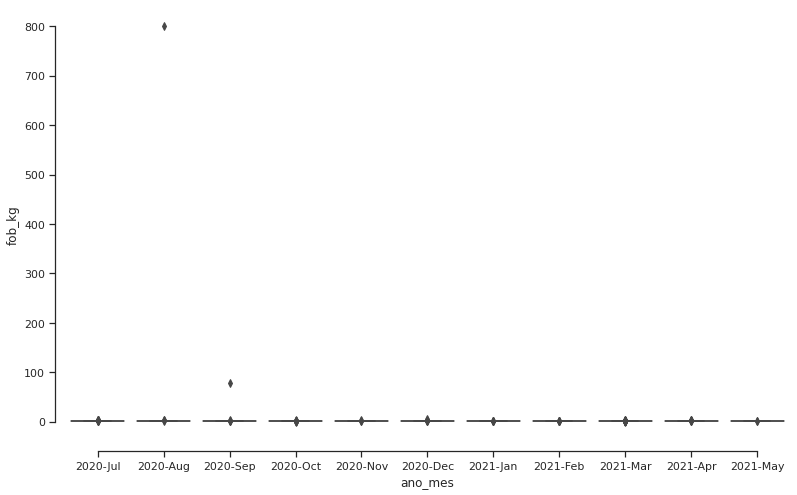

In [45]:
sns.set_theme(style="ticks", palette="pastel")
x = []
y = []

for year in ['2020','2021']:
    df_ano = df_filtrado[df_filtrado['ano'] == year]
    mes_grupos = df_ano['mes'].value_counts().index
    for mes_grup in mes_grupos:
        x.append(df_ano[df_ano['mes'] == mes_grup]['fob_kg'].to_list())
        y.append(f'{year}-{mes_grup}')

fig = plt.subplots(figsize=(13,8))

sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x="ano_mes", y="fob_kg",
            data=df_aed)

sns.despine(offset=10, trim=True)

plt.savefig('boxplot.png')

<h2>Eliminação de outliers considerados relevantes</h2>

In [46]:
print('Shape antes da remoção dos outliers',df_aed.shape)
df_aed.sort_values(by=['fob_kg'],ascending=False,inplace=True)
df_aed = df_aed.iloc[2:,:]
df_aed.sort_values(by=['ano','mes'],inplace=True)
print('Shape depois da remoção dos outliers',df_aed.shape)

Shape antes da remoção dos outliers (1182, 20)
Shape depois da remoção dos outliers (1180, 20)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



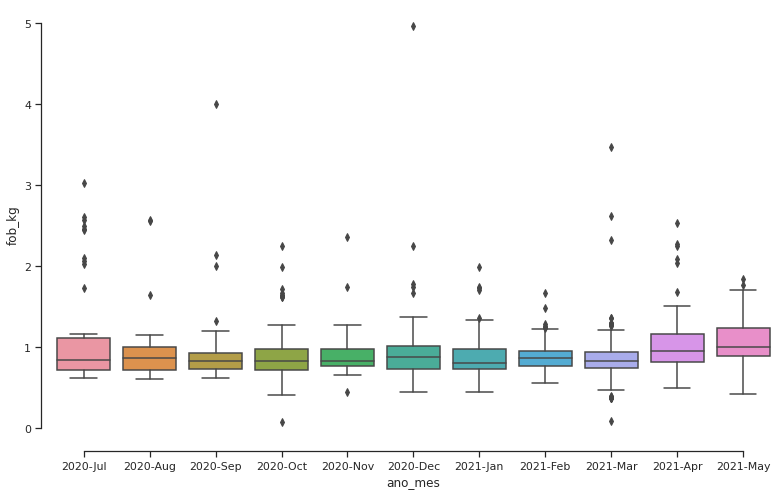

In [47]:
sns.set_theme(style="ticks", palette="pastel")
x = []
y = []

for year in ['2020','2021']:
    df_2021 = df_filtrado[df_filtrado['ano'] == year]
    mes_grupos = df_2021['mes'].value_counts().index
    for mes_grup in mes_grupos:
        x.append(df_2021[df_2021['mes'] == mes_grup]['fob_kg'].to_list())
        y.append(f'{year}-{mes_grup}')
fig = plt.subplots(figsize=(13,8))

sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x="ano_mes", y="fob_kg",
            data=df_aed)

sns.despine(offset=10, trim=True)

plt.savefig('boxplot.png')

<h2>Eliminação de outliers em 'df_filtrado' e nova plotagem gráfica das médias</h2>

In [48]:
print('Shape antes da remoção dos outliers',df_filtrado.shape)
df_filtrado.sort_values(by=['fob_kg'],ascending=False, inplace=True)
df_filtrado = df_filtrado.iloc[2:,:]
df_filtrado.sort_values(by=['ano','mes','item'],inplace=True)
print('Shape depois da remoção dos outliers',df_filtrado.shape)

Shape antes da remoção dos outliers (1182, 34)
Shape depois da remoção dos outliers (1180, 34)


<h3>Remoção dos outliers ressaltou as conclusões descritas acima</h3>

In [49]:
# objetos de armazenamento das médias mensais que serão criadas abaixo
media_mensal_fob_kg = []
media_mensal_incompat_fob_kg = []
media_mensal_compat_fob_kg = []

#aplicando as funções medias e plotmedias
medias(df_filtrado)
df_medias = pd.DataFrame(zip(df_wire_rod['Month'],
                             df_wire_rod['Wire Rod'],
                             media_mensal_fob_kg,
                             media_mensal_compat_fob_kg,
                             media_mensal_incompat_fob_kg),
                         columns=['Month','Wire Rod', 'media_mensal_fob_kg' ,'media_mensal_compat_fob_kg', 'media_mensal_incompat_fob_kg']
                         )
plotmedias(df_medias)
df_medias

,Month,Wire Rod,media_mensal_fob_kg,media_mensal_compat_fob_kg,media_mensal_incompat_fob_kg
0,Jul-2020,0.548,1.115472,1.115472,NaN
1,Aug-2020,0.555,0.947466,0.947466,NaN
2,Sep-2020,0.578,0.910649,0.910649,NaN
3,Oct-2020,0.587,0.904400,0.962522,0.403101
4,Nov-2020,0.602,0.885787,0.889316,0.441071
5,Dec-2020,0.637,0.945739,1.002189,0.570753
6,Jan-2021,0.772,0.869111,1.001003,0.694914
7,Feb-2021,0.798,0.877932,0.958851,0.716094
8,Mar-2021,0.805,0.865336,0.998567,0.685084
9,Apr-2021,0.806,1.032307,1.130072,0.731192


<h2>Análise de variáveis discretas</h2>
<h3>Plotagem de diagramas de dispersão</h3>
<b>
  

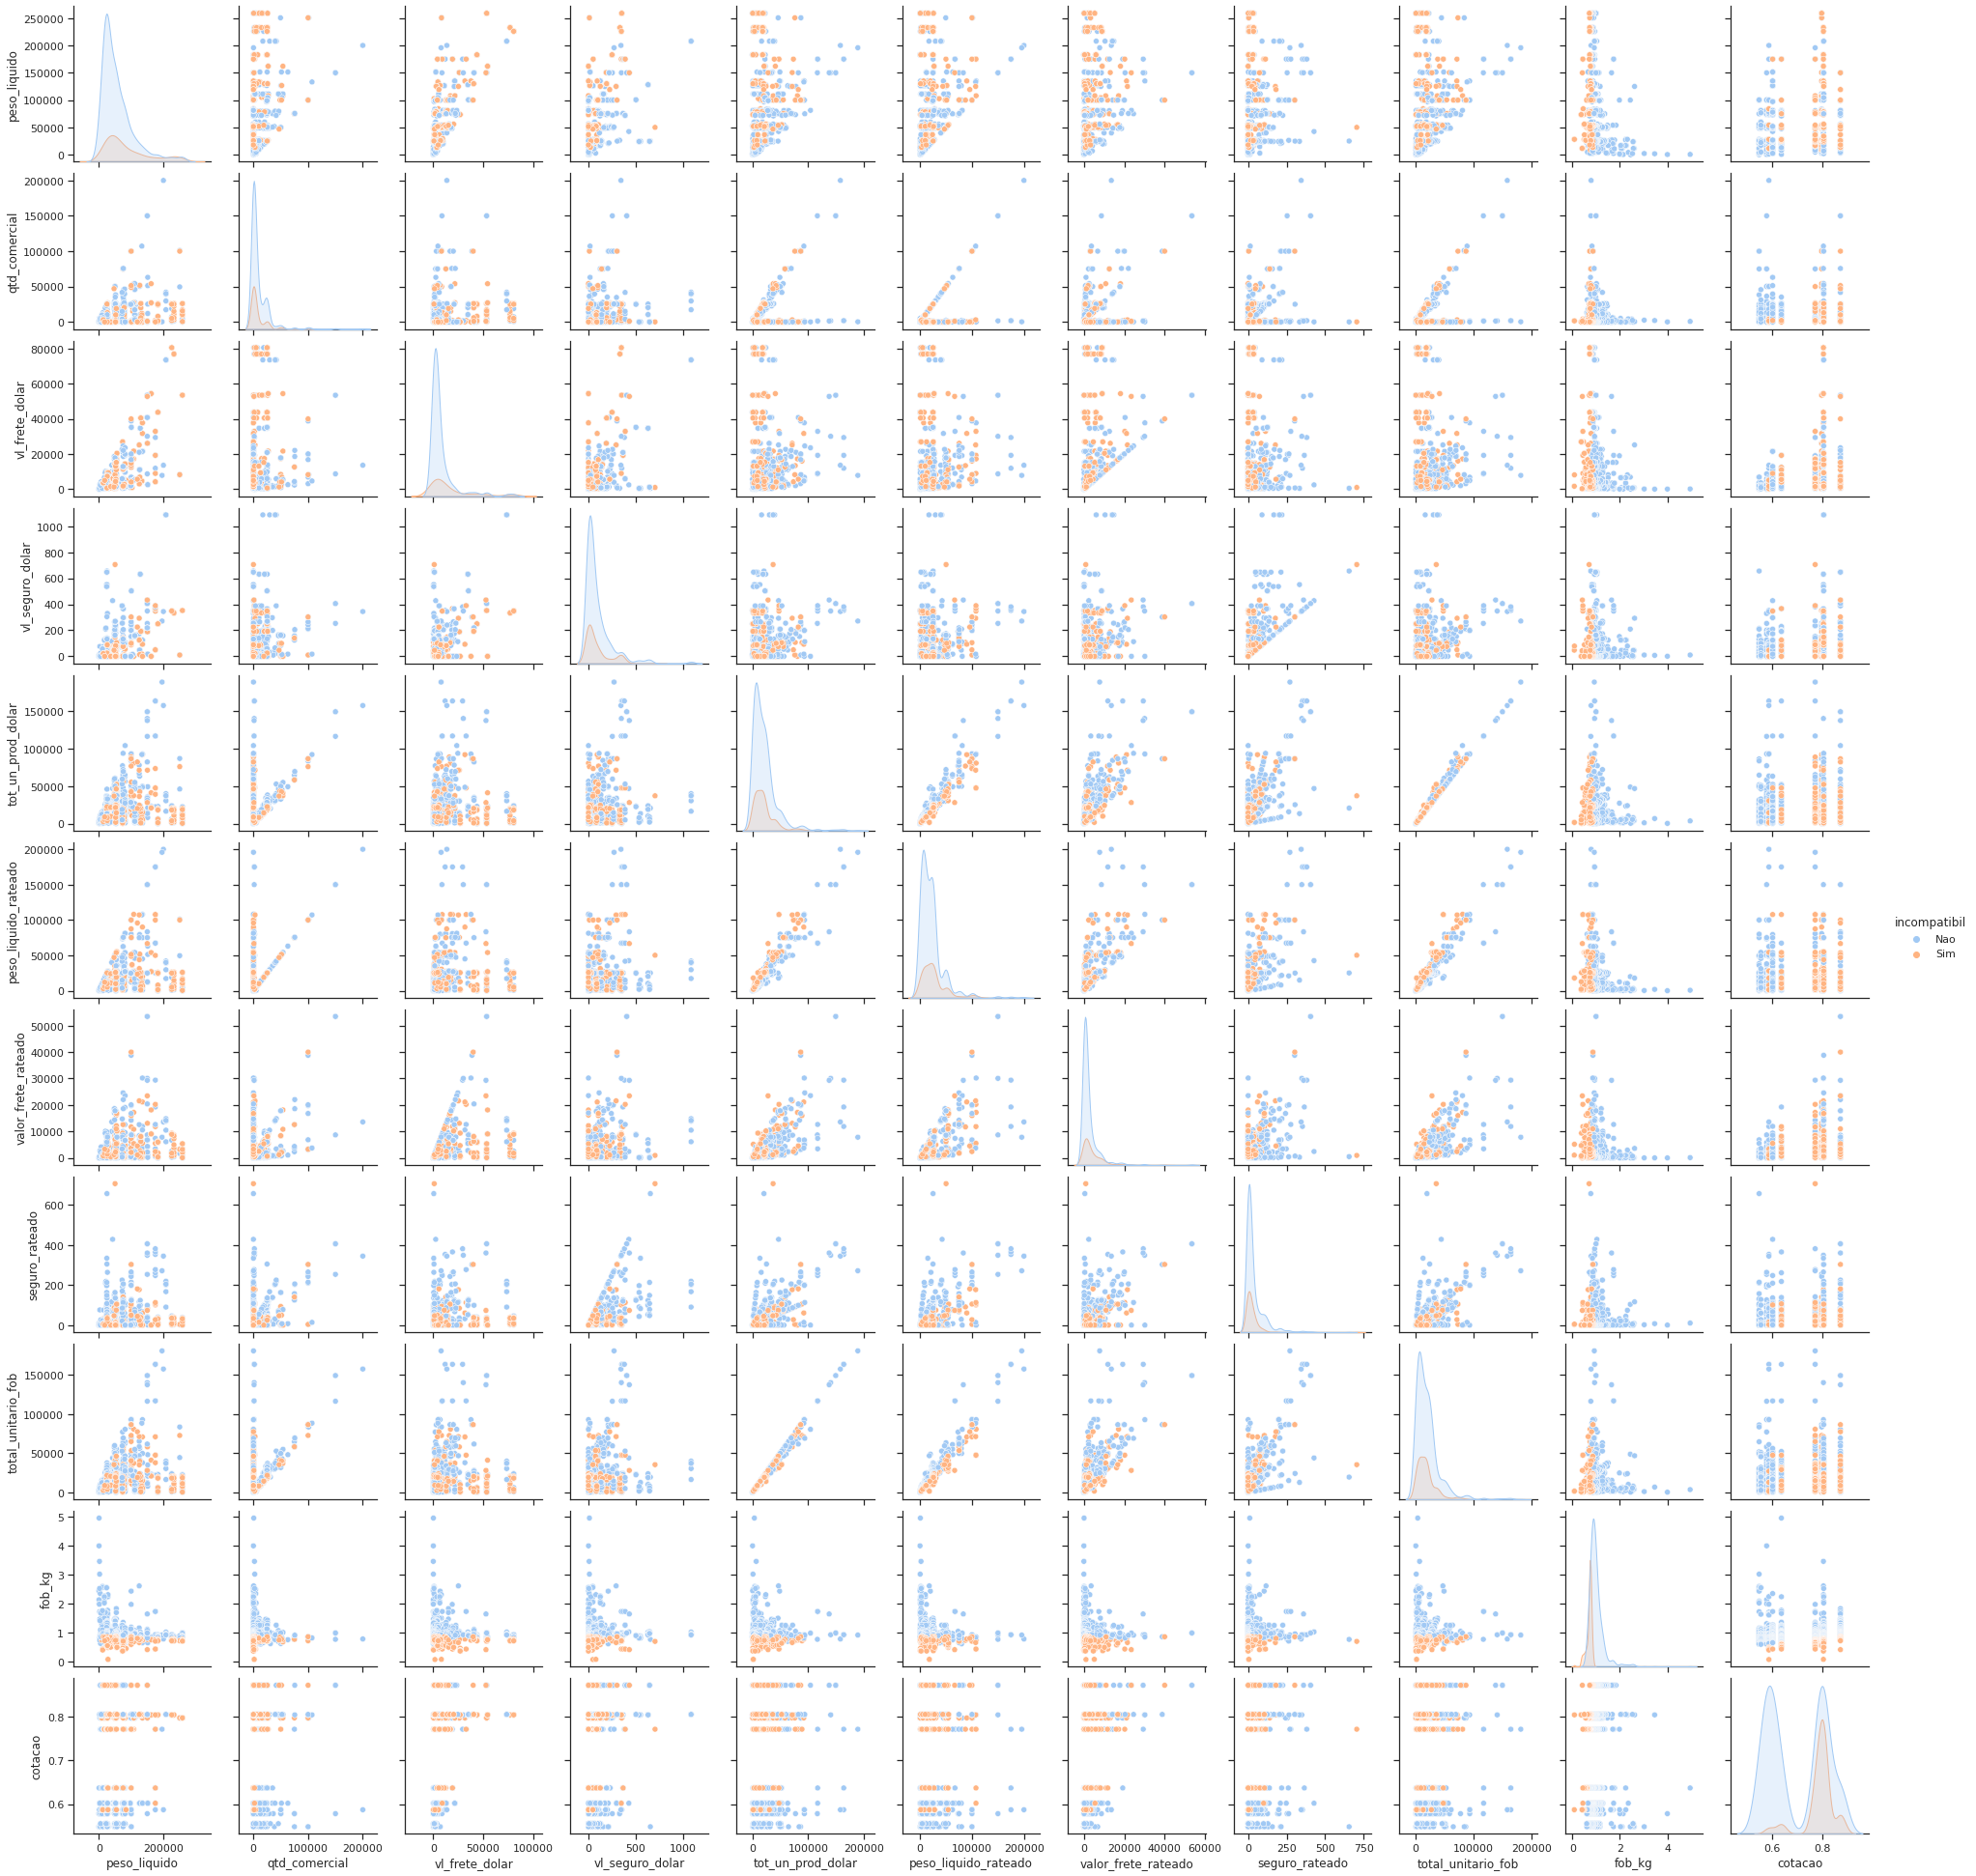

In [50]:
#plt.subplots(figsize=(12,10))
sns.pairplot(df_aed[[
    'peso_liquido',
    'qtd_comercial',
    'vl_frete_dolar',
    'vl_seguro_dolar',
    'tot_un_prod_dolar',
    'peso_liquido_rateado',
    'valor_frete_rateado',
    'seguro_rateado',
    'total_unitario_fob',
    'fob_kg',
    'cotacao',
    'incompatibil'
]],hue='incompatibil')

plt.savefig('relacao_variaveis.png')

<h2>HeatMap</h2>

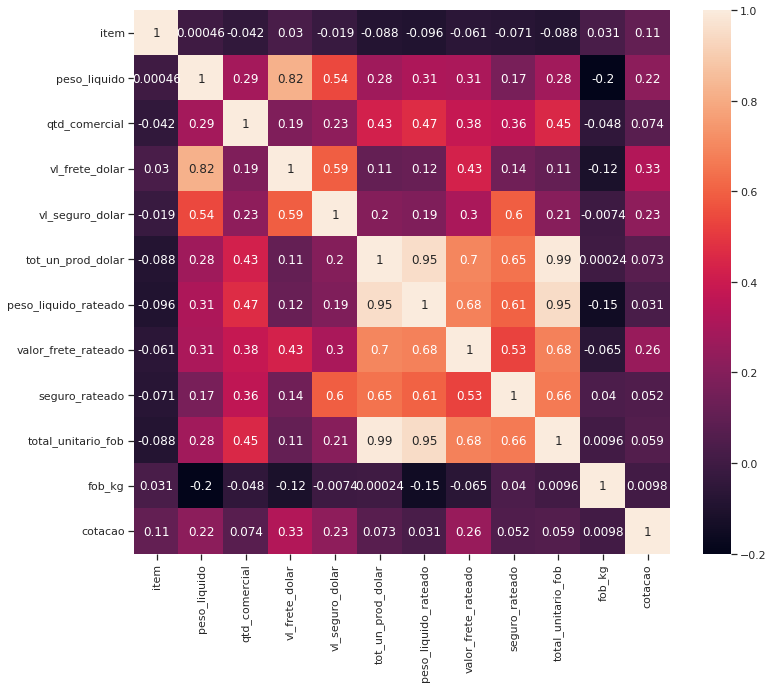

In [53]:
plt.subplots(figsize=(12,10))
sns.heatmap(df_aed.corr(),annot=True)
plt.savefig('heatmap.png')

<h2>Análise de variáveis categóricas</h2>

In [54]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Países de origem <br><sup>Produtos com valor declarado incompatível",
        xref="paper",
        x=0
    )
    )
fig.show()

In [55]:
info_pais_origem = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [56]:
info_pais_origem = df_filtrado['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Países de origem <br><sup>Todos Produtos",
        xref="paper",
        x=0
    )
    )
fig.show()

In [57]:
info_pais_origem = df_filtrado['pais_de_origem'].value_counts()

labels = info_pais_origem.index
values = info_pais_origem.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [58]:
info_pais_aquisicao = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_aquisicao'].value_counts()

labels = info_pais_aquisicao.index
values = info_pais_aquisicao.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="País de Aquisição<br><sup>Produtos com valor declarado incompatível</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [68]:
info_pais_aquisicao = df_filtrado[df_filtrado['incompatibil'] == 1]['pais_de_aquisicao'].value_counts()

labels = info_pais_aquisicao.index
values = info_pais_aquisicao.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [69]:
info_pais_aquisicao = df_filtrado['pais_de_aquisicao'].value_counts()

labels = info_pais_aquisicao.index
values = info_pais_aquisicao.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="País de Aquisição<br><sup>Todos Produtos</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [70]:
info_pais_aquisicao = df_filtrado['pais_de_aquisicao'].value_counts()

labels = info_pais_aquisicao.index
values = info_pais_aquisicao.to_list()


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [74]:
info_unid_desemb = df_filtrado[df_filtrado['incompatibil'] == 1]['unidade_desembaraco'].value_counts()

labels = info_unid_desemb.index
values = info_unid_desemb.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Unidade de desembaraço<br><sup>Produtos com valor declarado incompatível</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [73]:
info_unid_desemb = df_filtrado[df_filtrado['incompatibil'] == 1]['unidade_desembaraco'].value_counts()

labels = info_unid_desemb.index
values = info_unid_desemb.to_list()


import plotly.graph_objects as go


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

In [72]:
info_unid_desemb = df_filtrado['unidade_desembaraco'].value_counts()

labels = info_unid_desemb.index
values = info_unid_desemb.to_list()


import plotly.graph_objects as go


fig = go.Figure([go.Bar(x=values, y=labels, orientation='h')])
fig.update_layout(
    title=go.layout.Title(
        text="Unidade de desembaraço<br><sup>Todos Produtos</sup>",
        xref="paper",
        x=0
    )
    )
fig.show()

In [71]:
info_unid_desemb = df_filtrado['unidade_desembaraco'].value_counts()

labels = info_unid_desemb.index
values = info_unid_desemb.to_list()


import plotly.graph_objects as go


import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.show()

<h2>Exportando 'df_filtrado' em formato .csv</h2>
<h4><u>Dataset_preprocessado_TCC</u>: será utilizado no desenvolvimento dos modelos de ML </h4>


In [67]:
path = '/content/drive/MyDrive'
name = 'dataset_preprocessado_TCC'

if(not os.path.exists(path)):
    os.mkdir(path)

df_filtrado.to_csv(f'{path}/{name}',index=False)